In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *
import glob

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
import itertools

from saturation.utils import *

pio.renderers.default = "iframe"

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/10/04 14:32:56 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
24/10/04 14:32:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/04 14:32:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
base_path = "/data/saturation/thesis_run_20240929/"

configs_df = create_configs_df(read_configs(base_path, spark))
configs_pd = configs_df.toPandas()

configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    for k, v in read_config(Path(config_file))["run_configurations"].items():
        configs_dict[k] = v

In [5]:
configs_pd[configs_pd.slope.between(-4.1, -3.9)].sort_values("slope")

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
4,0.75,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.9,74,-4.0,250,2000
24,0.25,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.1,71,-4.0,250,2000
59,0.50,"{'name': 'radius_ratio', 'ratio': '1000000.0'}",1.0,6,-4.0,250,2000
63,0.50,"{'name': 'radius_ratio', 'ratio': '5.0'}",1.5,2,-4.0,250,2000
66,0.25,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.9,73,-4.0,250,2000
68,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.9,9,-4.0,250,2000
79,0.75,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,8,-4.0,250,2000
80,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,7,-4.0,250,2000
106,0.75,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.1,72,-4.0,250,2000
127,0.75,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.9,10,-4.0,250,2000


## Example CSFD

estimated slope=-2.024, sigma=0.063


/tmp/ipykernel_190668/1164536456.py:38: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



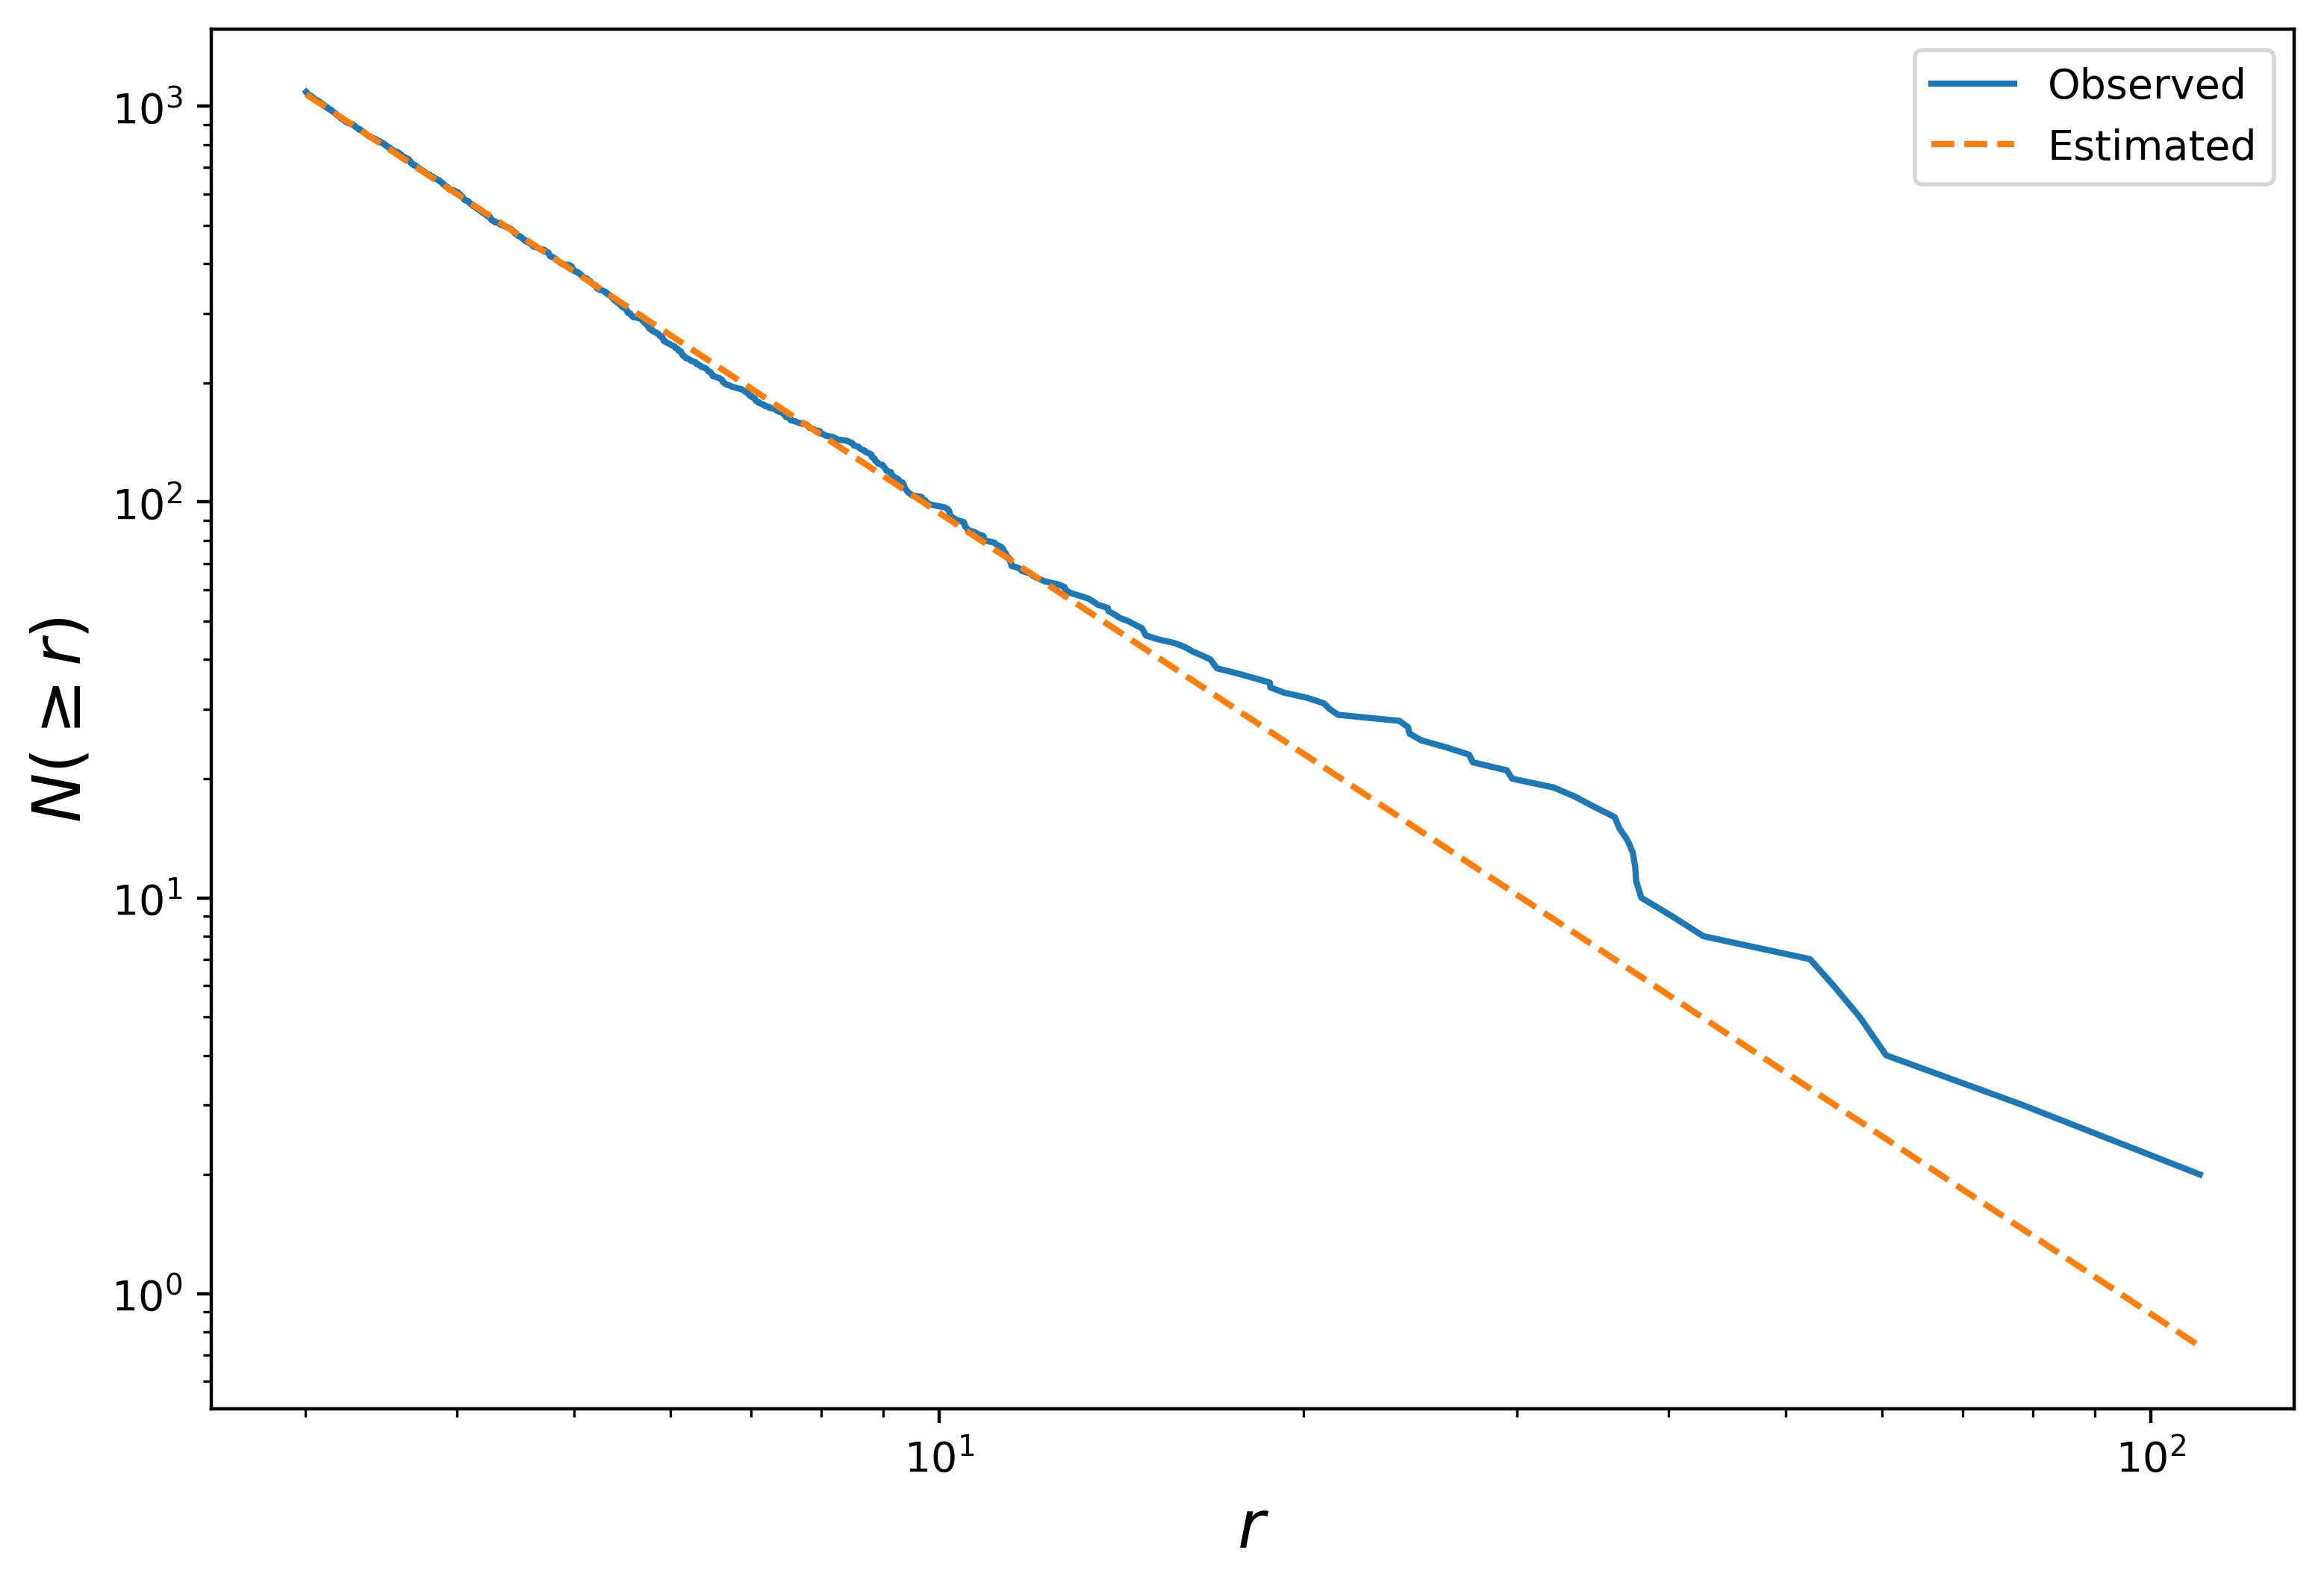

In [19]:
# Steep slope, -4.0
simulation_id = 73
target_ntot = 1e7

study_region_size = configs_dict[simulation_id]["study_region_size"]
r_stat = configs_dict[simulation_id]["r_stat"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = simulation_id
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

state = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_ntot,
    study_region_size,
    study_region_padding,
    spark
)   

estimated_slope, sigma = estimate_cumulative_slope(
    state.radius,
    state.radius.min(),
    state.radius.max(),
    min_search_slope=0.0,
    max_search_slope=10.0
)
intercept = estimate_intercept(state.radius, estimated_slope)
print(f"estimated slope={estimated_slope:.3f}, sigma={sigma:.3f}")

fig = plot_csfd_with_slope(state, -estimated_slope, intercept=intercept)
fig.show()

/tmp/ipykernel_190668/1081332667.py:12: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



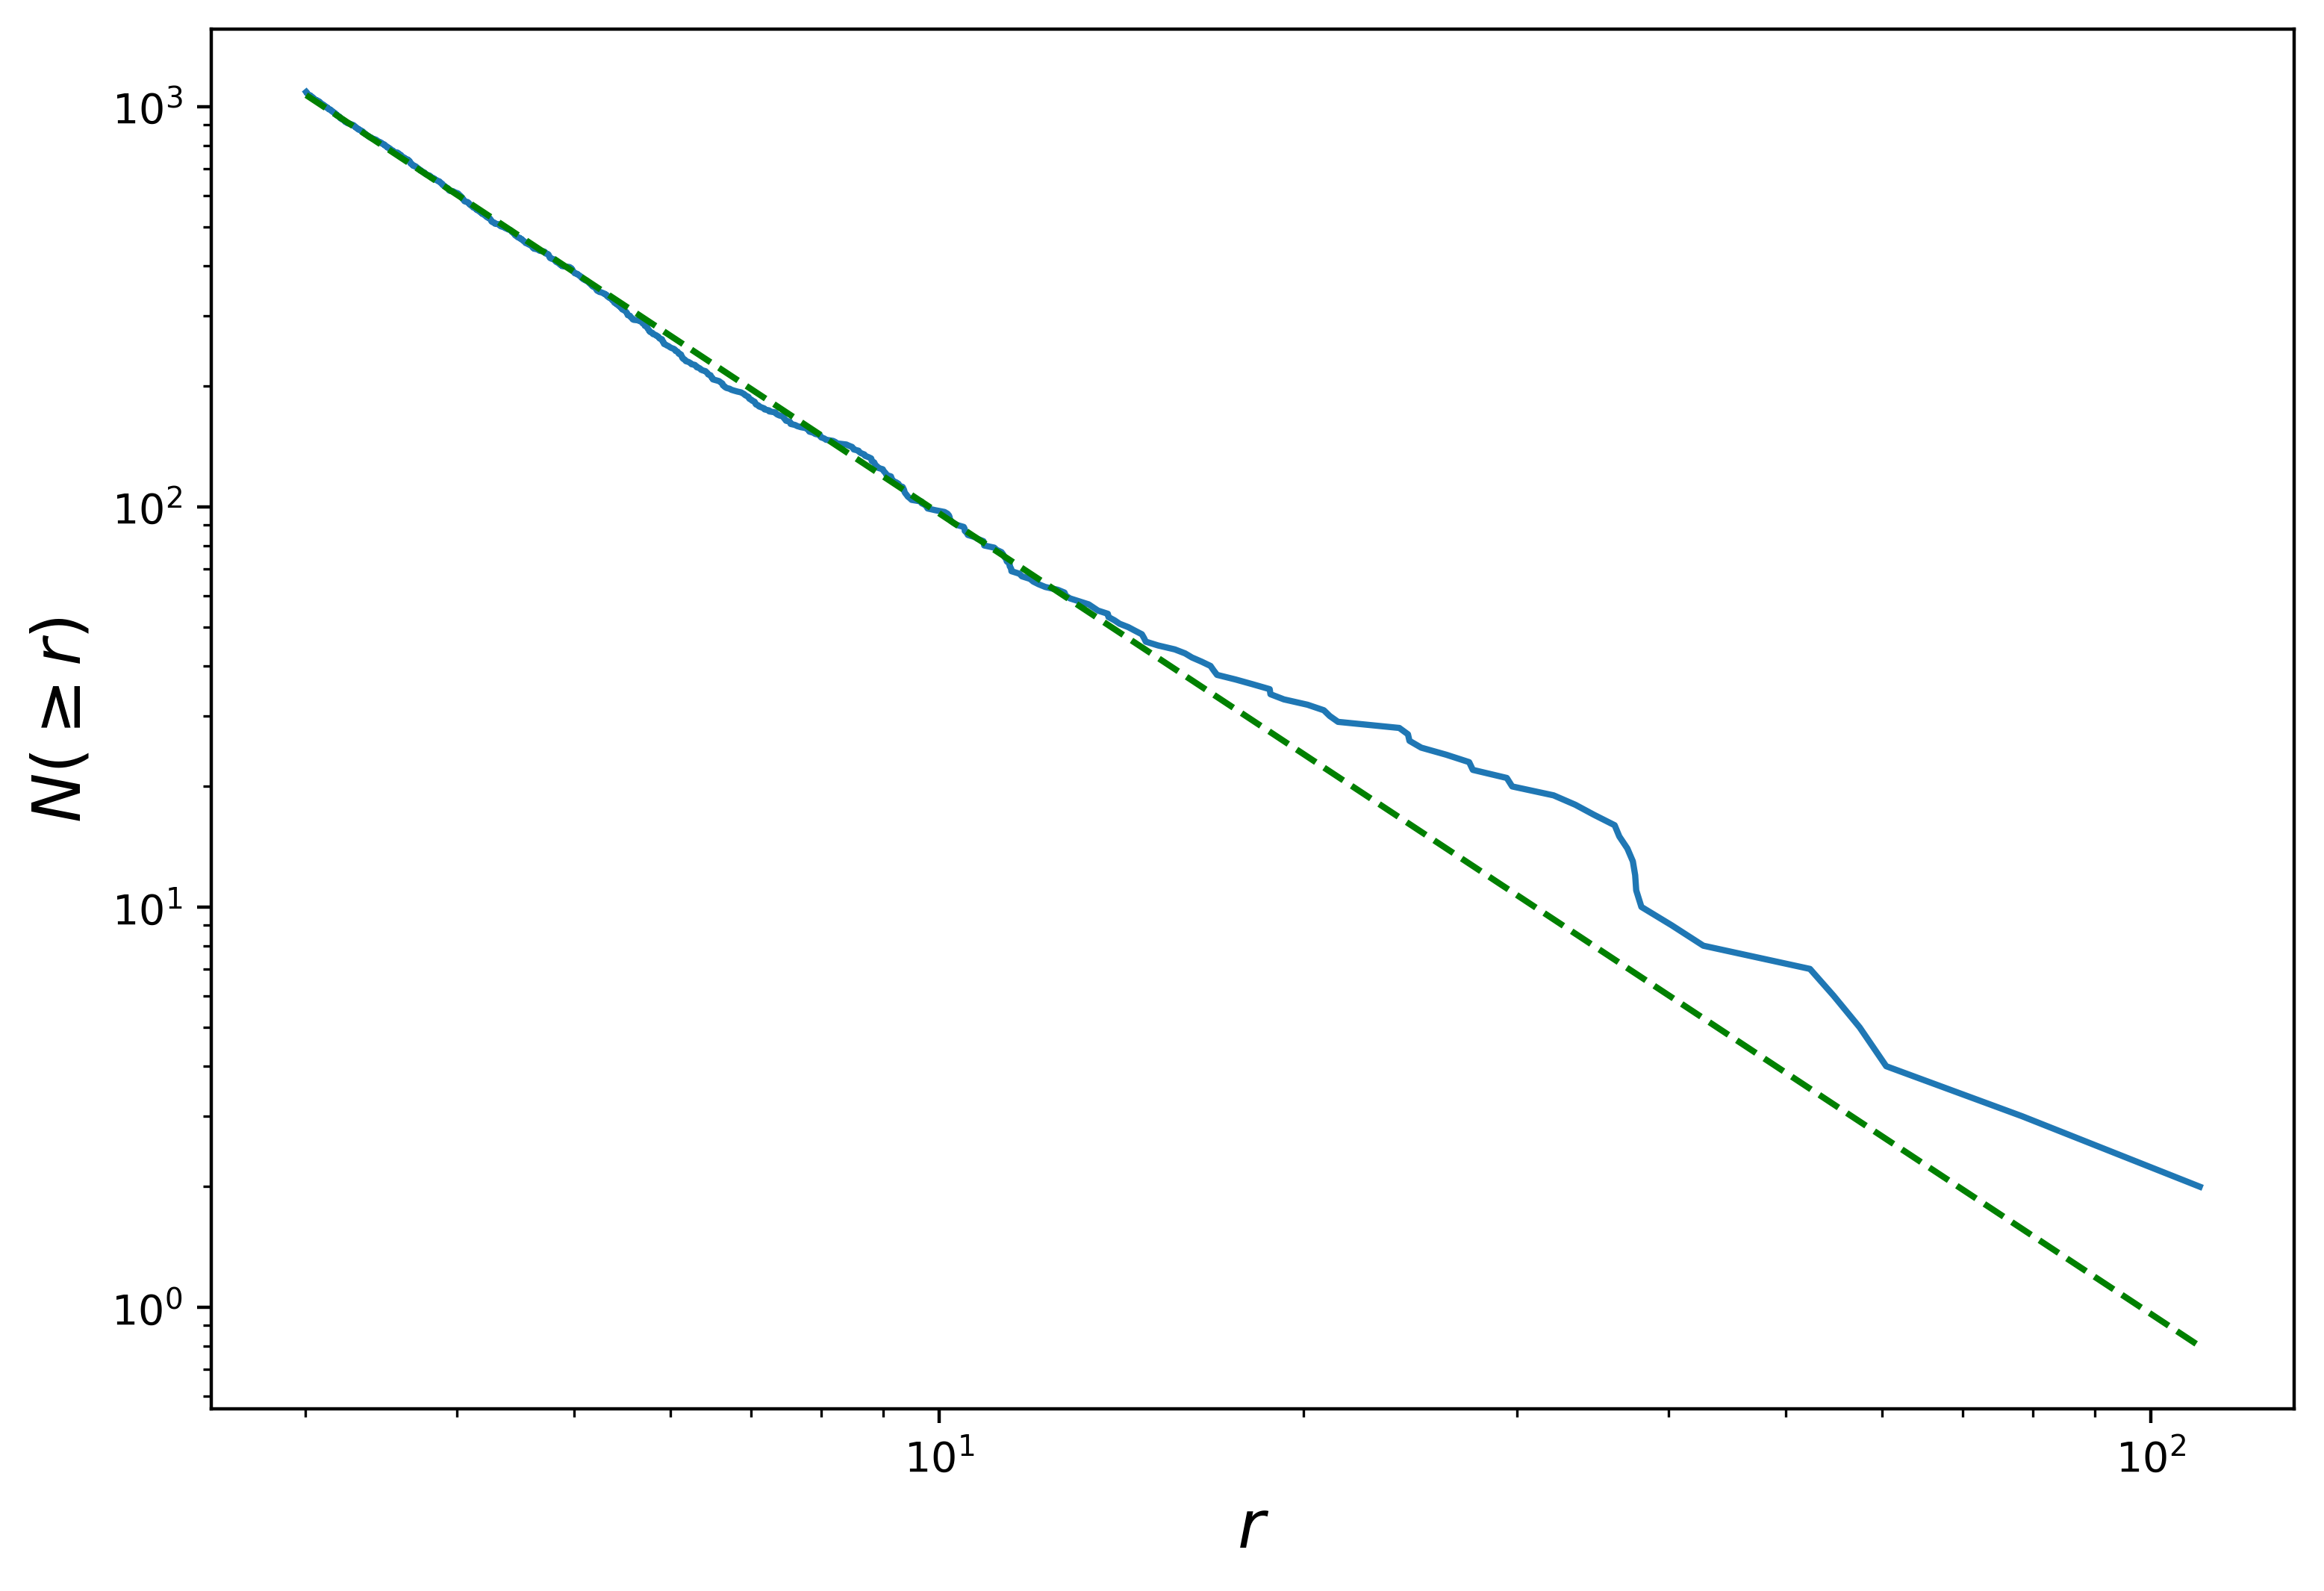

In [22]:
# Plotting just the CSFD
intercept = estimate_intercept(state.radius, -2.0)

fig = plot_csfd(state)

ax = fig.axes[0]
radii = state.radius.sort_values()
expected = intercept * radii ** -2
ax.plot(radii, expected, label="Estimated", ls="--", c="green")

fig.savefig(f"figures/example_csfd.png", bbox_inches="tight")
fig.show()